# Face Detection, Face Analysis, Face Recognition

Face detection and analysis: Detect human faces in an image and return the rectangle coordinates of their locations, and optionally with landmarks, and face-related attributes. This operation is required as a first step in all the other face recognition scenarios.

Face recognition: Confirm that a user is who they claim to be based on how closely their face data matches the target face. It includes Face verification ("one-to-one" matching).

Business Case:
Building Security where employee faces are saved into the system

Determine Input Requirements:
https://learn.microsoft.com/en-us/azure/ai-services/computer-vision/overview-identity#input-requirements

In [ ]:
%pip install --upgrade azure-ai-vision-face

## Load Azure Configuration

In [1]:
import os
azure_face_endpoint = os.environ["AZURE_FACE_ENDPOINT"]
azure_face_key = os.environ["AZURE_FACE_KEY"]

## Create Clients

In [2]:
import uuid

from azure.core.credentials import AzureKeyCredential
from azure.ai.vision.face import FaceAdministrationClient, FaceClient
from azure.ai.vision.face.models import FaceAttributeTypeRecognition04, FaceDetectionModel, FaceRecognitionModel, QualityForRecognition,  FaceAttributeTypeDetection03

face_admin_client = FaceAdministrationClient(endpoint=azure_face_endpoint, credential=AzureKeyCredential(azure_face_key))
face_client = FaceClient(endpoint=azure_face_endpoint, credential=AzureKeyCredential(azure_face_key))

## Helper Function

In [3]:
# Returns the file content of the image in the specified path
def read_file_content(file_path: str):
    with open(file_path, "rb") as fd:
        file_content = fd.read()
    return file_content

## Detect Faces

Detects the face and its attributes 

In [4]:
sample_file_path = "../Data/face/group/group_1.jpeg"

file_content = read_file_content(sample_file_path)

result = face_client.detect(
    file_content,
    detection_model=FaceDetectionModel.DETECTION03,  # The latest detection model.
    recognition_model=FaceRecognitionModel.RECOGNITION04,  # The latest recognition model.
    return_face_id=True,
    return_face_attributes=[
        FaceAttributeTypeDetection03.HEAD_POSE,
        FaceAttributeTypeDetection03.MASK,
        FaceAttributeTypeRecognition04.QUALITY_FOR_RECOGNITION,
    ],
    return_face_landmarks=True,
    return_recognition_model=True,
    face_id_time_to_live=120,
)

print(f"Detect faces from the file: {sample_file_path}")
# Print all detection results per line
for face in result:
    print(f"Face ID: {face.face_id}")
    print(f"Face Rectangle: {face.face_rectangle.as_dict()}")
    print(f"Face Landmarks:")
    for landmark, position in face.face_landmarks.as_dict().items():
        print(f"  {landmark}: {position}")
    print(f"Face Attributes: {face.face_attributes.as_dict()}")
    print(f"Recognition Model: {face.recognition_model}")
    print()

Detect faces from the file: ../Data/face/group/group_1.jpeg
Face ID: 743267f3-2525-4b6b-8fe3-f90b78adea07
Face Rectangle: {'top': 79, 'left': 482, 'width': 165, 'height': 234}
Face Landmarks:
  pupilLeft: {'x': 504.6, 'y': 187.9}
  pupilRight: {'x': 564.9, 'y': 182.5}
  noseTip: {'x': 521.1, 'y': 237.2}
  mouthLeft: {'x': 522.2, 'y': 255.0}
  mouthRight: {'x': 583.8, 'y': 250.3}
  eyebrowLeftOuter: {'x': 481.9, 'y': 160.8}
  eyebrowLeftInner: {'x': 504.9, 'y': 166.3}
  eyeLeftOuter: {'x': 495.8, 'y': 187.2}
  eyeLeftTop: {'x': 503.8, 'y': 183.6}
  eyeLeftBottom: {'x': 504.3, 'y': 192.2}
  eyeLeftInner: {'x': 514.4, 'y': 188.7}
  eyebrowRightInner: {'x': 536.2, 'y': 162.9}
  eyebrowRightOuter: {'x': 589.9, 'y': 154.0}
  eyeRightInner: {'x': 554.0, 'y': 185.2}
  eyeRightTop: {'x': 561.8, 'y': 176.9}
  eyeRightBottom: {'x': 565.9, 'y': 187.4}
  eyeRightOuter: {'x': 578.1, 'y': 180.6}
  noseRootLeft: {'x': 520.1, 'y': 190.3}
  noseRootRight: {'x': 536.1, 'y': 189.1}
  noseLeftAlarTop: {'x'

## Show the face bounding box and the landmark points

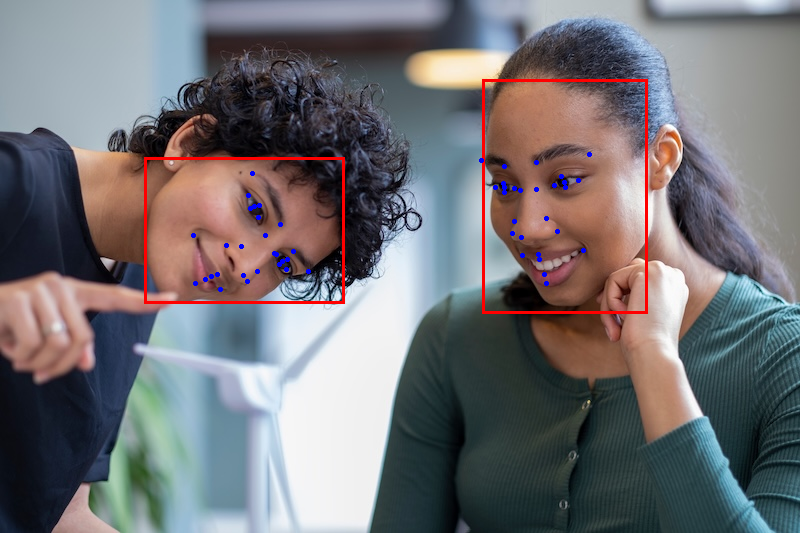

In [5]:
from PIL import Image, ImageDraw

image = Image.open(sample_file_path)
draw = ImageDraw.Draw(image)

for idx, face in enumerate(result):
    # Draw bounding box
    rect = face.face_rectangle
    left = rect.left
    top = rect.top
    right = left + rect.width
    bottom = top + rect.height
    draw.rectangle([left, top, right, bottom], outline="red", width=3)
    
    # Draw landmarks
    for landmark in face.face_landmarks.as_dict().values():
        x, y = landmark['x'], landmark['y']
        draw.ellipse((x-2, y-2, x+2, y+2), fill="blue")

# Save or display the image with bounding boxes and landmarks
#output_path = "../Data/images/group/group_1_with_boxes_and_landmarks.jpg"
#image.save(output_path)
image.show()

## Create Large Person Group

In [6]:
# Used in the Large Person Group Operations and Delete Large Person Group examples.
# LARGE_PERSON_GROUP_ID should be all lowercase and alphanumeric. For example, 'mygroupname' (dashes are OK).
LARGE_PERSON_GROUP_ID = str(uuid.uuid4())  # assign a random ID (or name it anything)

# Create a Large Person Group
print("Person group:", LARGE_PERSON_GROUP_ID)
face_admin_client.large_person_group.create(
    large_person_group_id=LARGE_PERSON_GROUP_ID,
    name=LARGE_PERSON_GROUP_ID,
    recognition_model=FaceRecognitionModel.RECOGNITION04,
)

Person group: f98dc193-c4ae-44c5-acd3-8812b51e98fa


## Add Persons to Group

In [7]:
# Define person
person_A = face_admin_client.large_person_group.create_person(
    large_person_group_id=LARGE_PERSON_GROUP_ID,
    name="Person A",
)

# Images
person_A_image_file_path = [
    "../Data/face/person_a/person_a1.jpeg",
    "../Data/face/person_a/person_a2.jpeg",
]

for image in person_A_image_file_path:
    # Read the image file
    file_content = read_file_content(image)

    # Check if the image is of sufficient quality for recognition.
    result = face_client.detect(
        file_content,
        detection_model=FaceDetectionModel.DETECTION03,  # The latest detection model.
        recognition_model=FaceRecognitionModel.RECOGNITION04,  # The latest recognition model.
        return_face_id=True,
        return_face_attributes=[FaceAttributeTypeRecognition04.QUALITY_FOR_RECOGNITION]
    )

    # Ensure only one face is detected and it has high quality for recognition
    if len(result) == 1 and result[0].face_attributes.quality_for_recognition == QualityForRecognition.HIGH:
        face_admin_client.large_person_group.add_face(
            LARGE_PERSON_GROUP_ID,
            person_A.person_id,
            file_content,
            detection_model=FaceDetectionModel.DETECTION03,        
    )
        
    print(f"Face {result[0].face_id} added to person {person_A.person_id}")

Face f50e9197-9e99-4c70-8684-1cc7d8414794 added to person 7c59c52b-a53c-4f7d-89e6-5412646b6073
Face d6f7d73f-b380-478e-9a93-f737891c1183 added to person 7c59c52b-a53c-4f7d-89e6-5412646b6073


In [9]:
# Define woman friend
person_B = face_admin_client.large_person_group.create_person(
    large_person_group_id=LARGE_PERSON_GROUP_ID,
    name="Person B",
)

# Images
person_B_image_file_path = [
    "../Data/face/person_b/person_b1.jpeg",
    "../Data/face/person_b/person_b2.jpeg",
]

for image in person_B_image_file_path:
    # Read the image file
    file_content = read_file_content(image)

    # Check if the image is of sufficient quality for recognition.
    result = face_client.detect(
        file_content,
        detection_model=FaceDetectionModel.DETECTION03,  # The latest detection model.
        recognition_model=FaceRecognitionModel.RECOGNITION04,  # The latest recognition model.
        return_face_id=True,
        return_face_attributes=[FaceAttributeTypeRecognition04.QUALITY_FOR_RECOGNITION]
    )

    # Ensure only one face is detected and it has high quality for recognition
    if len(result) == 1 and result[0].face_attributes.quality_for_recognition == QualityForRecognition.HIGH:
        face_admin_client.large_person_group.add_face(
            LARGE_PERSON_GROUP_ID,
            person_B.person_id,
            file_content,
            detection_model=FaceDetectionModel.DETECTION03,        
    )
        
    print(f"Face {result[0].face_id} added to person {person_B.person_id}")

Face 64862949-a58b-4d09-bb22-2dbb527b712c added to person f4af188b-cff7-4a59-a2a9-edcbfbcda51a
Face 58f0a0ea-f57d-4c61-8ec5-37bdae676f4a added to person f4af188b-cff7-4a59-a2a9-edcbfbcda51a


## Train the Large Person Group

In [10]:
# Train the large person group and set the polling interval to 5s
print(f"Train the person group {LARGE_PERSON_GROUP_ID}")
poller = face_admin_client.large_person_group.begin_train(
    large_person_group_id=LARGE_PERSON_GROUP_ID,
    polling_interval=5,
)

poller.wait()
print(f"The person group {LARGE_PERSON_GROUP_ID} is trained successfully.")

Train the person group f98dc193-c4ae-44c5-acd3-8812b51e98fa
The person group f98dc193-c4ae-44c5-acd3-8812b51e98fa is trained successfully.


## Identify Faces in Images

In [12]:
# Group image for testing against
image="../Data/face/group/group_2.jpeg"
file_content = read_file_content(image)

# Detect faces
face_ids = []
# We use detection model 03 to get better performance, recognition model 04 to support quality for recognition attribute.
# Check if the image is of sufficient quality for recognition.
faces = face_client.detect(
    file_content,
    detection_model=FaceDetectionModel.DETECTION03,  # The latest detection model.
    recognition_model=FaceRecognitionModel.RECOGNITION04,  # The latest recognition model.
    return_face_id=True,
    return_face_attributes=[FaceAttributeTypeRecognition04.QUALITY_FOR_RECOGNITION]
)

for face in faces:
    # Only take the face if it is of sufficient quality.
    if face.face_attributes.quality_for_recognition != QualityForRecognition.LOW:
        face_ids.append(face.face_id)

# Identify faces
identify_results = face_client.identify_from_large_person_group(
    face_ids=face_ids,
    large_person_group_id=LARGE_PERSON_GROUP_ID,
)
print("Identifying faces in image")
for identify_result in identify_results:
    if identify_result.candidates:
        print(f"Person is identified for face ID {identify_result.face_id} in image, with a confidence of "
              f"{identify_result.candidates[0].confidence}.")  # Get topmost confidence score

    # Verify faces
        verify_result = face_client.verify_from_large_person_group(
            face_id=identify_result.face_id,
            large_person_group_id=LARGE_PERSON_GROUP_ID,
            person_id=identify_result.candidates[0].person_id,
        )
        print(f"Person Identified: {identify_result.candidates[0].person_id}. Verification result: {verify_result.is_identical}. confidence: {verify_result.confidence}")
    else:
        print(f"No person identified for face ID {identify_result.face_id} in image.")


Identifying faces in image
Person is identified for face ID 78478837-7b6a-4b67-8a83-6460733f54ff in image, with a confidence of 0.94371.
Person Identified: f4af188b-cff7-4a59-a2a9-edcbfbcda51a. Verification result: True. confidence: 0.94371
Person is identified for face ID 2f6270db-08e7-4b9e-acaf-a2aabdd7ab58 in image, with a confidence of 0.97506.
Person Identified: 7c59c52b-a53c-4f7d-89e6-5412646b6073. Verification result: True. confidence: 0.97506


## [Optional] Identify Faces in Images and place bounding boxes

Identifying faces in image
Person is identified for face ID 81d79171-00cf-412f-97eb-79b411783886 in image, with a confidence of 0.94372.
Person Identified: f4af188b-cff7-4a59-a2a9-edcbfbcda51a. Verification result: True. confidence: 0.94372
Person is identified for face ID 182947e4-1828-4e0c-87b5-fba0d079d640 in image, with a confidence of 0.97505.
Person Identified: 7c59c52b-a53c-4f7d-89e6-5412646b6073. Verification result: True. confidence: 0.97505


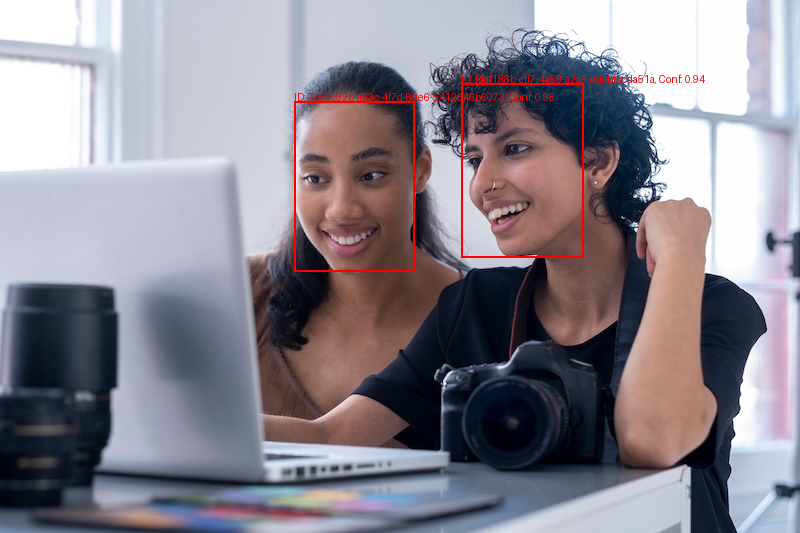

In [13]:
from PIL import Image, ImageDraw, ImageFont

# Group image for testing against
image_path = "../Data/face/group/group_2.jpeg"
file_content = read_file_content(image_path)

# Detect faces
face_ids = []
face_rectangles = {}
# We use detection model 03 to get better performance, recognition model 04 to support quality for recognition attribute.
# Check if the image is of sufficient quality for recognition.
faces = face_client.detect(
    file_content,
    detection_model=FaceDetectionModel.DETECTION03,  # The latest detection model.
    recognition_model=FaceRecognitionModel.RECOGNITION04,  # The latest recognition model.
    return_face_id=True,
    return_face_attributes=[FaceAttributeTypeRecognition04.QUALITY_FOR_RECOGNITION]
)

# Open the image using PIL
image = Image.open(image_path)
draw = ImageDraw.Draw(image)
font = ImageFont.load_default()

for face in faces:
    # Only take the face if it is of sufficient quality.
    if face.face_attributes.quality_for_recognition != QualityForRecognition.LOW:
        face_ids.append(face.face_id)
        # Store face rectangle for later use
        face_rectangles[face.face_id] = face.face_rectangle
        # Draw bounding box
        rect = face.face_rectangle
        left = rect.left
        top = rect.top
        right = left + rect.width
        bottom = top + rect.height
        draw.rectangle(((left, top), (right, bottom)), outline="red", width=2)

# Identify faces
identify_results = face_client.identify_from_large_person_group(
    face_ids=face_ids,
    large_person_group_id=LARGE_PERSON_GROUP_ID,
)
print("Identifying faces in image")
for identify_result in identify_results:
    if identify_result.candidates:
        person_id = identify_result.candidates[0].person_id
        confidence = identify_result.candidates[0].confidence
        print(f"Person is identified for face ID {identify_result.face_id} in image, with a confidence of {confidence}.")  # Get topmost confidence score

        # Verify faces
        verify_result = face_client.verify_from_large_person_group(
            face_id=identify_result.face_id,
            large_person_group_id=LARGE_PERSON_GROUP_ID,
            person_id=person_id,
        )
        print(f"Person Identified: {person_id}. Verification result: {verify_result.is_identical}. confidence: {verify_result.confidence}")

        # Draw person ID and confidence on the image
        rect = face_rectangles[identify_result.face_id]
        left = rect.left
        top = rect.top
        draw.text((left, top - 10), f"ID: {person_id}, Conf: {confidence:.2f}", fill="red", font=font)
    else:
        print(f"No person identified for face ID {identify_result.face_id} in image.")

# Save or display the image with bounding boxes and labels
image.show()  # To display the image
#image.save("output_image_with_bounding_boxes_and_labels.jpg")  # To save the image

## Clean up resources

In [14]:
# Delete the large person group
face_admin_client.large_person_group.delete(LARGE_PERSON_GROUP_ID)
print(f"The person group {LARGE_PERSON_GROUP_ID} is deleted.")

The person group f98dc193-c4ae-44c5-acd3-8812b51e98fa is deleted.
